In [23]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, roc_auc_score, precision_recall_curve, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from imblearn.combine import SMOTEENN

import tensorflow as tf

pd.options.display.max_columns = None

In [2]:
df_covid = pd.read_csv('./Covid_clean.csv')

Contenido del Dataset


The dataset was provided by the Mexican government (link). This dataset contains an enormous number of anonymized patient-related information including pre-conditions. The raw dataset consists of 21 unique features and 1,048,576 unique patients. In the Boolean features, 1 means "yes" and 2 means "no". values as 97 and 99 are missing data.

- sex: 1 for female and 2 for male.
- age: of the patient.
- classification: covid test findings. Values 1-3 mean that the patient was diagnosed with covid in different
- degrees. 4 or higher means that the patient is not a carrier of covid or that the test is inconclusive.
- patient type: type of care the patient received in the unit. 1 for returned home and 2 for hospitalization.
- pneumonia: whether the patient already have air sacs inflammation or not.
- pregnancy: whether the patient is pregnant or not.
- diabetes: whether the patient has diabetes or not.
- copd: Indicates whether the patient has Chronic obstructive pulmonary disease or not.
- asthma: whether the patient has asthma or not.
- inmsupr: whether the patient is immunosuppressed or not.
- hypertension: whether the patient has hypertension or not.
- cardiovascular: whether the patient has heart or blood vessels related disease.
- renal chronic: whether the patient has chronic renal disease or not.
- other disease: whether the patient has other disease or not.
- obesity: whether the patient is obese or not.
- tobacco: whether the patient is a tobacco user.
- usmr: Indicates whether the patient treated medical units of the first, second or third level.
- medical unit: type of institution of the National Health System that provided the care.
- intubed: whether the patient was connected to the ventilator.
- icu: Indicates whether the patient had been admitted to an Intensive Care Unit.
- date died: If the patient died indicate the date of death, and 9999-99-99 otherwise.
- fallecidos: 1 for yes and 2 for no.

In [3]:
#dropeamos lo que no me sirve como final clasification

df_covid.drop(['USMER', 'MEDICAL_UNIT', 'CLASIFFICATION_FINAL', 'DATE_DIED', 'PATIENT_TYPE'], axis=1, inplace=True)

In [4]:
# reemplazo los valores 2 por 0 en todo el dataset

df_covid.replace(2, 0, inplace=True)

df_covid.head()

,SEX,PNEUMONIA,AGE,DIABETES,COPD,ASTHMA,INMSUPR,HIPERTENSION,OTHER_DISEASE,CARDIOVASCULAR,OBESITY,RENAL_CHRONIC,TOBACCO,fallecidos
0,1,1.0,65.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1
1,0,1.0,72.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,1
2,0,0.0,55.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
3,1,0.0,53.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
4,0,0.0,68.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1


# Rebalanceo 
## Combinado smote-enn

In [5]:
clase_mayoritaria = df_covid[df_covid['fallecidos'] == 0]
clase_minoritaria = df_covid[df_covid['fallecidos'] == 1]

X = df_covid.drop('fallecidos', axis=1)
y = df_covid['fallecidos']

# Aplico smote-enn

smote_enn = SMOTEENN(random_state=101)

X_resampled, y_resampled = smote_enn.fit_resample(X, y)

# creo el dataframe con los datos balanceados

df_covid_balanceado = pd.concat([pd.DataFrame(X_resampled), pd.DataFrame(y_resampled)], axis=1)

In [6]:
# creamos el modelo de clasificacion

X = df_covid_balanceado.drop('fallecidos', axis=1)
y = df_covid_balanceado['fallecidos']



In [7]:
# dividimos el dataset en train y test

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)




# RED NEURONAL

In [8]:
# Normalizar los datos
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

### Creamos la RED

Creamos una red basica con 3 capaz y entrenamos durante 10 epocas con tamaño de lotes de 32. 

In [25]:
# red neuronal entrenar

model = tf.keras.Sequential([
    tf.keras.layers.Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test))

# salvamos checkpointweights

model.save_weights('./checkpoints_smote_enn/my_checkpoint')




Epoch 1/10
28144/28144 [==============================] - 31s 1ms/step - loss: 0.1332 - accuracy: 0.9535 - val_loss: 0.1045 - val_accuracy: 0.9658
Epoch 2/10
28144/28144 [==============================] - 30s 1ms/step - loss: 0.0979 - accuracy: 0.9668 - val_loss: 0.0948 - val_accuracy: 0.9650
Epoch 3/10
28144/28144 [==============================] - 27s 968us/step - loss: 0.0890 - accuracy: 0.9695 - val_loss: 0.0964 - val_accuracy: 0.9661
Epoch 4/10
28144/28144 [==============================] - 28s 1ms/step - loss: 0.0844 - accuracy: 0.9707 - val_loss: 0.0817 - val_accuracy: 0.9721
Epoch 5/10
28144/28144 [==============================] - 26s 931us/step - loss: 0.0803 - accuracy: 0.9716 - val_loss: 0.0816 - val_accuracy: 0.9690
Epoch 6/10
28144/28144 [==============================] - 29s 1ms/step - loss: 0.0773 - accuracy: 0.9727 - val_loss: 0.0798 - val_accuracy: 0.9709
Epoch 7/10
28144/28144 [==============================] - 29s 1ms/step - loss: 0.0751 - accuracy: 0.9734 - val_los

In [26]:
# exportamos el modelo

model.save('modelo_smote_enn.h5')

Evaluamos

In [11]:
#evaluamos el modelo

loss, accuracy = model.evaluate(X_test, y_test)
print('Loss:', loss)
print('Accuracy:', accuracy)

# Obtener las predicciones del modelo
y_pred = model.predict(X_test)
y_pred = (y_pred > 0.5).astype(int)

precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print('Precision:', precision)
print('Recall:', recall)
print('F1:', f1)



7036/7036 [==============================] - 4s 624us/step - loss: 0.0617 - accuracy: 0.9789
Loss: 0.06165313720703125
Accuracy: 0.9789426326751709
7036/7036 [==============================] - 4s 520us/step
Precision: 0.9641893087883884
Recall: 0.9830361271839294
F1: 0.9735215106310493


Matriz de confusion

7036/7036 [==============================] - 4s 533us/step


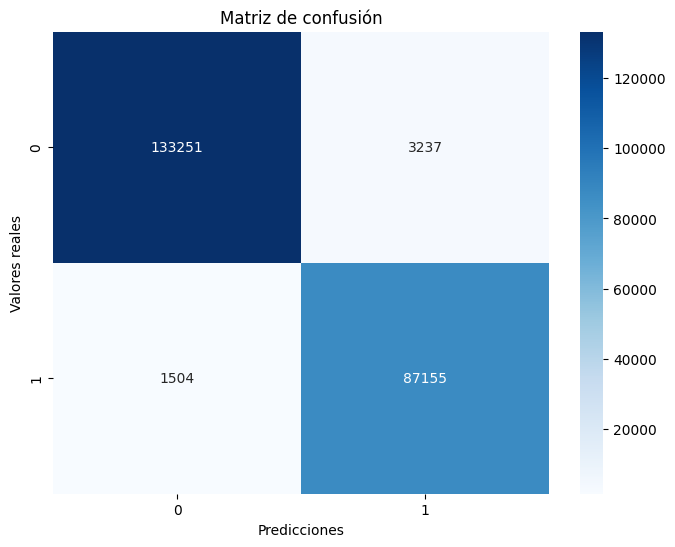

In [12]:
# Obtener las predicciones del modelo
y_pred = model.predict(X_test)
y_pred = (y_pred > 0.5).astype(int)

# Calcular la matriz de confusión
cm = confusion_matrix(y_test, y_pred)

# Visualizar la matriz de confusión
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicciones')
plt.ylabel('Valores reales')
plt.title('Matriz de confusión')
plt.show()

CURVA ROC

Curva ROC (Receiver Operating Characteristic): Es un gráfico que muestra la tasa de verdaderos positivos frente a la tasa de falsos positivos a medida que varías el umbral de clasificación. Puedes utilizar matplotlib o scikit-learn para trazar la curva ROC y calcular el área bajo la curva (AUC-ROC) para evaluar el rendimiento del modelo.

7036/7036 [==============================] - 4s 531us/step


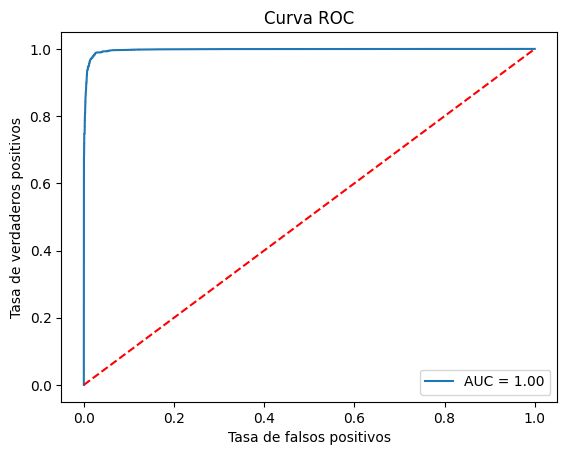

In [13]:
# Calcular las probabilidades de predicción del modelo
y_pred = model.predict(X_test)

# Calcular la tasa de verdaderos positivos y la tasa de falsos positivos
fpr, tpr, thresholds = roc_curve(y_test, y_pred)

# Calcular el área bajo la curva ROC (AUC-ROC)
auc = roc_auc_score(y_test, y_pred)

# Visualizar la curva ROC
plt.plot(fpr, tpr, label=f'AUC = {auc:.2f}')
plt.plot([0, 1], [0, 1], 'r--')
plt.xlabel('Tasa de falsos positivos')
plt.ylabel('Tasa de verdaderos positivos')
plt.title('Curva ROC')
plt.legend()
plt.show()

Curva de Precision y Recall

Curva ROC (Receiver Operating Characteristic): Es un gráfico que muestra la tasa de verdaderos positivos frente a la tasa de falsos positivos a medida que varías el umbral de clasificación. Puedes utilizar matplotlib o scikit-learn para trazar la curva ROC y calcular el área bajo la curva (AUC-ROC) para evaluar el rendimiento del modelo.

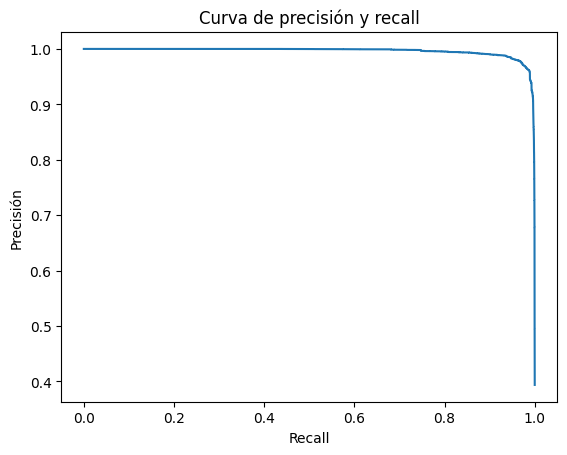

In [14]:
from sklearn.metrics import precision_recall_curve

# Calcular la precisión y el recall para diferentes umbrales
precision, recall, thresholds = precision_recall_curve(y_test, y_pred)

# Visualizar la curva de precisión y recall
plt.plot(recall, precision)
plt.xlabel('Recall')
plt.ylabel('Precisión')
plt.title('Curva de precisión y recall')
plt.show()

# random forest

In [15]:
# dividimos el dataset en train y test

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Entrenamos un modelo de random forest con 100 arboles y evaluamos

In [16]:
# entrenamos el modelo

rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)



RandomForestClassifier(random_state=42)

Evaluamos

In [17]:

# predecimos

y_pred = rf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print('Accuracy: ', accuracy)
precision = precision_score(y_test, y_pred)
print('Precision: ', precision)
recall = recall_score(y_test, y_pred)
print('Recall: ', recall)
f1 = f1_score(y_test, y_pred)
print('F1: ', f1)


Accuracy:  0.9984410185345575
Precision:  0.9986222784352696
Recall:  0.9974170698970212
F1:  0.998019310313694


Vemos la importancia de cada variable

In [18]:
# vemos la importancia de las variables

importances = pd.DataFrame({'feature':X_train.columns,'importance':np.round(rf.feature_importances_,3)})
importances = importances.sort_values('importance',ascending=False).set_index('feature')
print(importances)

                importance
feature                   
PNEUMONIA            0.423
AGE                  0.312
DIABETES             0.061
HIPERTENSION         0.059
RENAL_CHRONIC        0.027
SEX                  0.025
OTHER_DISEASE        0.020
OBESITY              0.015
COPD                 0.013
TOBACCO              0.013
INMSUPR              0.011
CARDIOVASCULAR       0.011
ASTHMA               0.010


Hacemos un grafico de la importancia de cada variable en el modelo para comprender que variables es mas importante para el modelo y para el resultado buscado. 

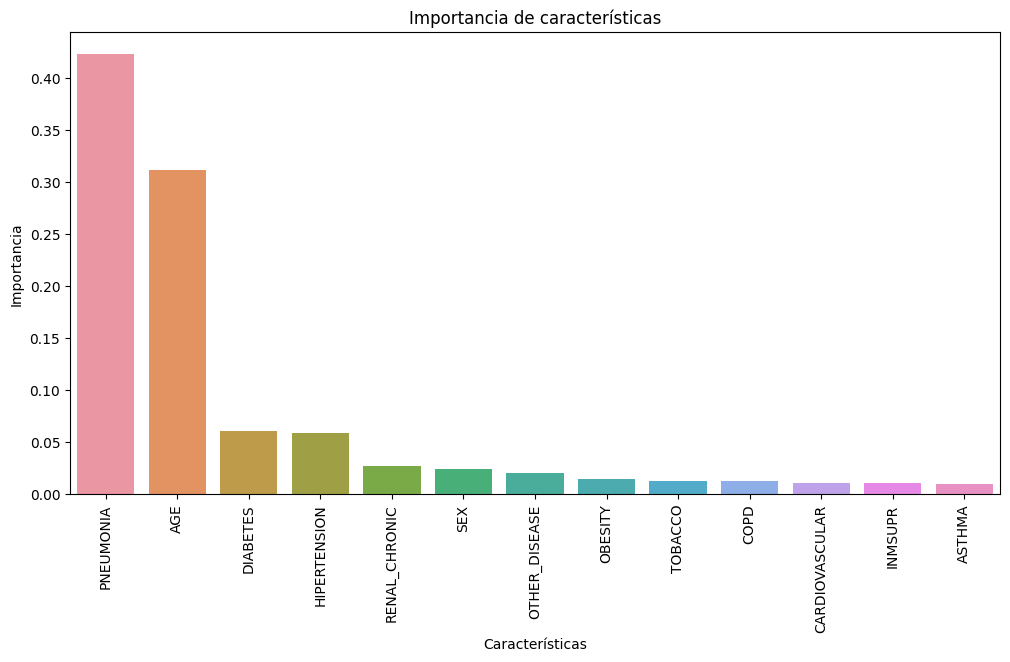

In [19]:
# Obtener los valores de importancia de características y sus nombres

feature_importances = rf.feature_importances_
feature_names = X_train.columns

# Crear un dataframe con los valores de importancia de características y sus nombres

feature_importances_df = pd.DataFrame({'feature_importances': feature_importances,
                                        'feature_names': feature_names})

# Ordenar los valores de importancia de características de mayor a menor

feature_importances_df.sort_values('feature_importances', ascending=False, inplace=True)

# Crear un gráfico de barras con los valores de importancia de características

plt.figure(figsize=(12, 6))

sns.barplot(x=feature_importances_df.feature_names, y=feature_importances_df.feature_importances)

plt.title('Importancia de características')

plt.xlabel('Características')

plt.ylabel('Importancia')

plt.xticks(rotation=90)

plt.show()

Matriz de confusion

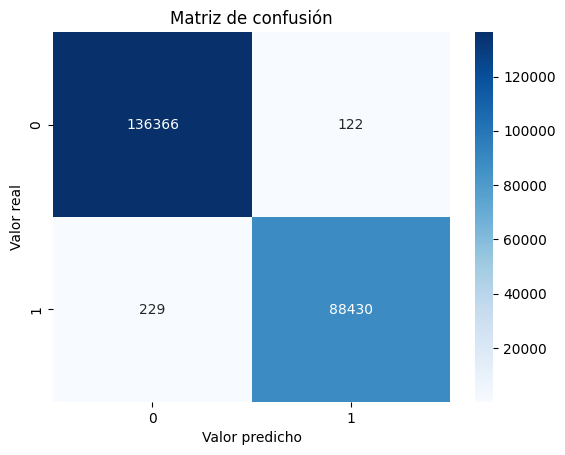

In [20]:
#creamos matriz de confusion

cm = confusion_matrix(y_test, y_pred)

#creamos el heatmap

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')

plt.title('Matriz de confusión')

plt.xlabel('Valor predicho')

plt.ylabel('Valor real')

plt.show()

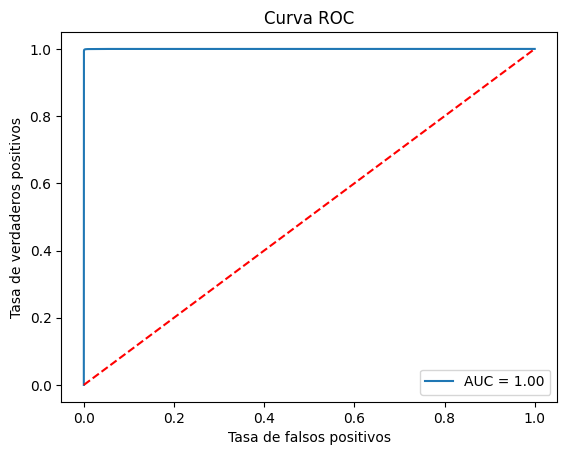

In [21]:
# curva roc

# Calcular las probabilidades de predicción del modelo

y_pred_proba = rf.predict_proba(X_test)

# Calcular la tasa de verdaderos positivos y la tasa de falsos positivos

fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba[:, 1])

# Calcular el área bajo la curva ROC (AUC-ROC)

auc = roc_auc_score(y_test, y_pred_proba[:, 1])

# Visualizar la curva ROC

plt.plot(fpr, tpr, label=f'AUC = {auc:.2f}')

plt.plot([0, 1], [0, 1], 'r--')

plt.xlabel('Tasa de falsos positivos')

plt.ylabel('Tasa de verdaderos positivos')

plt.title('Curva ROC')

plt.legend()

plt.show()

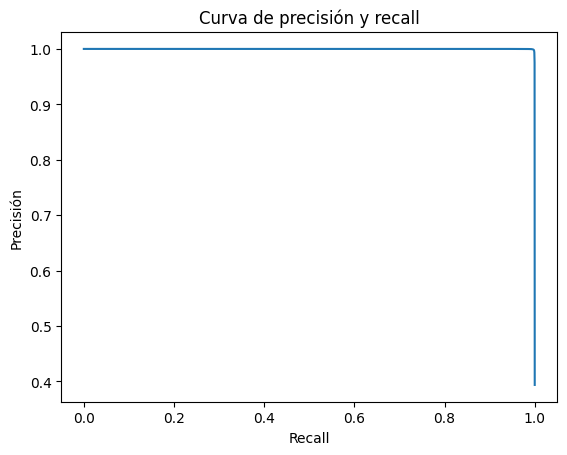

In [22]:
# curva recall precision

# Calcular la precisión y el recall para diferentes umbrales

precision, recall, thresholds = precision_recall_curve(y_test, y_pred_proba[:, 1])

# Visualizar la curva de precisión y recall

plt.plot(recall, precision)

plt.xlabel('Recall')

plt.ylabel('Precisión')

plt.title('Curva de precisión y recall')

plt.show()

#### Conclusiones:

Como podes ver, el modelo de red neuronal tiene un accuracy de 0.93 y el modelo de random forest tiene un accuracy de 0.93. Ambos metodos nos dan un resultado similar. Lo que nos dice que el modelo de red neuronal no es mejor que el modelo de random forest. Pero tambien que 0.93 es un resultado posiblemente mejorable. 

- Red Neuronal
    933/933 [==============================] - 1s 633us/step - loss: 0.3473 - 
    
    
    - Loss: 0.34729814529418945
    - Accuracy: 0.8547830581665039
    - Precision: 0.842410944759938
    - Recall: 0.8734109460725278
    - F1: 0.857630904671178

- Random Forest
    - Accuracy:  0.846171888088457
    - Precision:  0.8418620006602839
    - Recall:  0.8530710558008832
    - F1:  0.8474294639593234
    